In [ ]:
# if you're missing any of the below libraries, install here. 
import sys
!{sys.executable} -m pip install jupyter_dash


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pgeocode
import quandl

In [2]:
# import reference df for regions
# region_df = pd.read_csv(r'C:\Users\jacheung\Dropbox\Datasets\Zillow\ZILLOW-REGIONS.csv')
# indicators_df = pd.read_csv(r'C:\Users\jacheung\Dropbox\Datasets\Zillow\ZILLOW_INDICATORS.csv')

region_df = pd.read_csv(r'/Users/jonathancheung/Dropbox/Datasets/Zillow/ZILLOW-REGIONS.csv')
indicators_df = pd.read_csv(r'/Users/jonathancheung/Dropbox/Datasets/Zillow/ZILLOW_INDICATORS.csv')


la_region_id = region_df[region_df['region'].str.contains('Los Angeles', regex=False)]
la_region_id.reset_index(drop=True,inplace=True)


In [3]:
# build a look up table for los angeles
# extract out zip codes
zipcode = [k.split(';')[0] for k in la_region_id['region'] if k.split(';')[0].isdigit()]
idx = [idx for idx,k in enumerate(la_region_id['region']) if k.split(';')[0].isdigit()]
la_lookup = la_region_id.loc[idx]
la_lookup['zipcode'] = zipcode

# transform zip codes to lat long
nomi = pgeocode.Nominatim('us')
def get_lat_long(zipcode):
    vals = nomi.query_postal_code(zipcode)
    return vals['latitude'], vals['longitude']

lat_long_raw = [get_lat_long(k) for k in la_lookup['zipcode']]
lat_long_insert =np.array([np.array(xi) for xi in lat_long_raw])

la_lookup['latitude'] = lat_long_insert[:,0]
la_lookup['longitude'] = lat_long_insert[:,1]


In [4]:
# build median home values across all zip codes using quandl API
quandl.ApiConfig.api_key = 'wX4VKujcwjcKqguwo1hR'
df = pd.DataFrame()
for region_id, zipcode in zip(la_lookup['region_id'],la_lookup['zipcode']):
    data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=str(region_id))
    data['date'] = data['date'].astype('datetime64[M]')
    data['value'] = data['value']/10**6
    group_data = data.groupby(by=['date']).aggregate('median').rename(columns = {'value':zipcode})
    df = pd.concat([df, group_data], axis=1)
    
df.reset_index(inplace=True)

pct_df = df.loc[:,(df.columns != 'date')].pct_change(axis=0,periods=12) * 100
pct_df = pd.concat([pct_df,df['date']],axis=1)


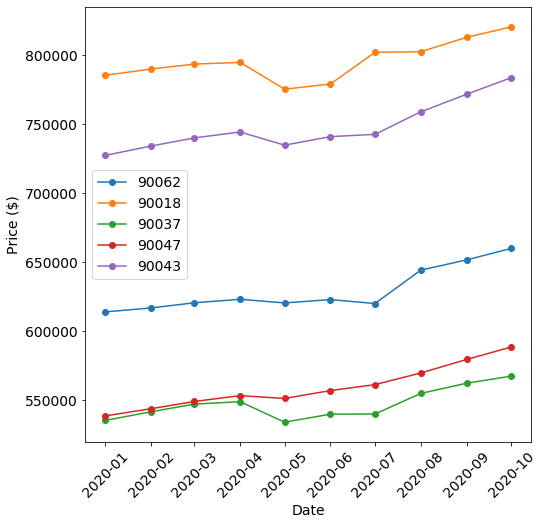

In [134]:

plt.figure(figsize = (8,8))
plt.rcParams.update({'font.size': 14})

def plot_zipcode(zipcode):
    reg_id = la_lookup.loc[la_lookup['zipcode']==zipcode,'region_id']

    data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=str(np.array(reg_id)[0]))
    data['date'] = data['date'].astype('datetime64[M]')
    data = data.groupby(by=['date']).aggregate(['median','count'])

    plt.plot(data.index[-10:],data['value']['median'][-10:],'-o')
    plt.xlabel('Date')
    plt.xticks(rotation = 45)
    plt.ylabel('Price ($)')
    plt.legend(zipcode)

selected_zips = ['90062','90018','90037','90047','90043']
for k in selected_zips:
    plot_zipcode(k)
plt.legend(selected_zips)
plt.show()

In [18]:
# bokeh plotting 
from bokeh.plotting import figure
from bokeh.io import output_file,show
from bokeh.models import HoverTool, CategoricalColorMapper, ColumnDataSource
from bokeh.models.widgets import Tabs, Panel

source = ColumnDataSource(df)

p = figure(title = 'SFH house price', x_axis_type = 'datetime', 
           x_axis_label = 'Date', y_axis_label = 'House price in millions (USD)')

p.circle('date', '90062', source=source, size =3, color = 'red', legend_label='Leimert Park')
p.circle('date', '90007', source=source, size =3,color = 'green', legend_label='USC NW')
p.circle('date', '90025', source=source, size =3,color = 'blue', legend_label='Westwood')
p.legend.location = "top_left"

source = ColumnDataSource(pct_df)
p1 = figure(title = 'SFH house price', x_axis_type = 'datetime', 
           x_axis_label = 'Date', y_axis_label = 'Yearly percent change in house price')
p1.circle('date', '90062', source=source, size =3, color = 'red', legend_label = 'Leimert Park')
p1.circle('date', '90007', source=source, size =3,color = 'green', legend_label='USC NW')
p1.circle('date', '90025', source=source, size =3,color = 'blue', legend_label = 'Westwood')
p1.legend.location = "top_left"

tab1 = Panel(child=p, title='Median home values')
tab2 = Panel(child=p1, title='Yearly percent change')

# Create a Tabs layout: layout
layout = Tabs(tabs=[tab1, tab2])
show(layout)

In [14]:
from bokeh.plotting import figure
from bokeh.io import output_file,show
from bokeh.models import HoverTool, ColumnDataSource, CustomJS
from bokeh.models.widgets import Tabs, Panel
from bokeh.layouts import row

s1 = ColumnDataSource(la_lookup)
p1 = figure(x_axis_label = 'latitude', y_axis_label = 'longitude',tools="lasso_select")
p1.circle('latitude','longitude',source=s1,size=2)

s2 = ColumnDataSource(data=dict(x=[], y=[]))
p2 = figure(x_axis_label = 'test')
p2.circle('x', 'y', source=s2, alpha=0.6)
s1.selected.js_on_change('indices', CustomJS(args=dict(s1=s1, s2=s2), code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
        }
        s2.change.emit();
    """)
)

layout = row(p1, p2)

show(layout)

(361, 6)

In [ ]:
import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

scatter_df = df.set_index('date').transpose()
scatter_df = pd.concat([scatter_df, la_lookup.set_index('zipcode')], axis=1, sort=False)
scatter_df.drop(columns = ['region_id', 'region_type','region'], inplace=True)

time_idx = [idx for idx, k in enumerate(scatter_df.columns) if type(k) == type(pd.to_datetime(dt.now()))]
sel_dates = scatter_df.columns[time_idx]
keys = [val for idx, val in enumerate(sel_dates) if ((idx+1)/6).is_integer()]
values = [str(val.month) + '/' + str(val.year) for val in keys]
res = {keys[i]: values[i] for i in range(len(keys))} 


slim_df = scatter_df[res.keys()]
slim_df = pd.concat([slim_df, la_lookup.set_index('zipcode')], axis=1, sort=False)
slim_df.drop(columns = ['region_id', 'region_type','region'], inplace=True)
slim_df = slim_df.rename(columns = res)
res = {values[i]: values[i] for i in range(len(values))} 

app = JupyterDash(__name__)
# app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Slider(
        id='year-slider',
        min=values[0],
        max=values[-1],
        value=values[0],
        step=None,
        marks=res),
    dcc.Graph(id='graph-with-slider')

])

@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('year-slider', 'value')])
def update_figure(selected_year):
    year = str(selected_year)
#     year = pd.to_datetime(selected_year)
#     selected_df = scatter_df[[year,'latitude','longitude']].dropna()
#     selected_df[year] = selected_df[year]/10
    selected_df = slim_df[[year,'latitude','longitude']].dropna()
    selected_df[year] = selected_df[year]/10
    fig = px.scatter_mapbox(selected_df, lat="latitude", 
                            lon="longitude", 
                            hover_data=[selected_df.index],
                            size = year)

    fig.update_layout(mapbox_style='open-street-map',transition_duration=500)
    
    return fig
# 
# app.run_server(debug=True)
app.run_server(mode='inline')

In [ ]:
slim_df['6/1996']

In [ ]:

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


time_idx = [idx for idx, k in enumerate(scatter_df.columns) if type(k) == type(pd.to_datetime(dt.now()))]
sel_dates = scatter_df.columns[time_idx]

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


app.layout = html.Div([
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        id='year-slider',
        min=sel_dates.min(),
        max=sel_dates.max(),
        value=sel_dates.min(),
        marks={str(year): str(year) for year in sel_dates.unique()},
        step=None
    )
])


@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('year-slider', 'value')])

def update_figure(selected_year):
    
    fig = px.scatter_mapbox(scatter_df, lat="latitude", lon="longitude", hover_data=[scatter_df.index], size =selected_year)
    fig.update_layout(mapbox_style='open-street-map',transition_duration=500)
    
    return fig


app.run_server(debug=True)

In [ ]:
{str(year): str(year) for year in sel_dates.unique()}

# Plotting